# **Anomaly Detection in Time Series Data**

This notebook aims to identify anomalous patterns within a time series dataset by building models trained on normal activity data and testing them on both normal and (fall detection).

#### Dataset overview

The MobiAct Dataset is designed for the analysis of human activities, particularly focusing on different types of falls and daily living activities (ADLs). The dataset includes data from 66 participants performing falls and 19-66 participants performing various ADLs.


In [1]:
import numpy as np
import pandas as pd
import os
import glob
import random

# Preprocessing

Explanation
Directory Path: The data_dir variable should be set to the path of the main directory containing your annotated data directories.

Reading Files: We loop through each activity directory within the main directory and then loop through each file in these directories. For each file, we extract metadata (activity type, sensor type, participant ID, and trial number) from the filename.

Reading Data: Each CSV file is read into a DataFrame using pd.read_csv. No header is present in the data files (header=None).

Combining Data: Metadata columns are added to each DataFrame, and these DataFrames are appended to a list. All DataFrames in the list are then concatenated into a single DataFrame using pd.concat.

Optional Saving: The combined DataFrame is saved to a new CSV file named combined_mobiact_dataset.csv.

In [2]:
### TO DO 
# try to obtain the same repartition in every classes 

# Denoising the data with frequency domain cleaning High and low pass filters... 

# might need only 2 classification output, falls or not falls 
# not the all datas 

## try to use gru instead of lstm to avoid overfitting (check arch diag in lesson)

def load_and_combine_data(data_folder, sample_percentage=100):
    # Recursively search for all activity folders
    activity_folders = glob.glob(os.path.join(data_folder, '*'))
    
    # Create an empty list to store the data
    all_data = []

    # Iterate through each activity folder
    for activity_folder in activity_folders:
        print(f"Processing activity folder: {activity_folder}")
        
        # Search for all CSV files within the current activity folder
        data_files = glob.glob(os.path.join(activity_folder, '*.csv'))
        
        # Shuffle the list of data files to ensure random sampling
        random.shuffle(data_files)
        
        # Calculate the number of files to load based on the sample percentage
        num_files_to_load = int(len(data_files) * sample_percentage / 100)
        
        # Iterate through each CSV file in the current activity folder
        for i, file in enumerate(data_files):
            if i < num_files_to_load:
                file_path = os.path.abspath(file)
                data = pd.read_csv(file_path)
                
                # Extract metadata from the filename
                parts = os.path.basename(file).split('_')
                activity_type = parts[0]
                sensor_type = parts[1]
                participant_id = parts[2]
                trial_no = parts[3].split('.')[0]
                
                # Add metadata columns to the DataFrame
                data['Activity Type'] = activity_type
                data['Sensor Type'] = sensor_type
                data['Participant ID'] = participant_id
                data['Trial No'] = trial_no
                
                all_data.append(data)
                #### print(f"Loaded {i+1}/{num_files_to_load} files for this activity.")
    
    # Concatenate all the loaded data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    
    return combined_data

# Define the path to the annotated data folder
data_folder = '/kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data'
sample_percentage = 3  # Load only 30% of the dataset

# Load and combine data from all activity folders with sampling
combined_data = load_and_combine_data(data_folder, sample_percentage)

# Export combined data to a CSV file
output_file = 'combined_mobiact_dataset.csv'
combined_data.to_csv(output_file, index=False)
print(f"Combined data exported to {output_file}")

Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/FOL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/CSO
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/STU
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SDL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SLH
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SCH
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/STN
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SBE
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/WAL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated

## 1. Load the Combined Dataset
We'll load the dataset using pandas.

In [3]:
import pandas as pd

# Load the combined dataset
file_path = '/kaggle/working/combined_mobiact_dataset.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()

,timestamp,rel_time,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,azimuth,pitch,roll,label,Activity Type,Sensor Type,Participant ID,Trial No
0,419803971000,0.000000,1.139463,9.650947,-2.207436,-1.246776,0.748615,0.058338,0.00000,0.000000,-0.000000,STD,FOL,9,1,annotated
1,419809067000,0.005096,1.055384,9.613112,-2.199028,-1.251663,0.734260,0.066584,359.98425,0.359908,-0.210357,STD,FOL,9,1,annotated
2,419813981000,0.010010,0.995988,9.586384,-2.193089,-1.244943,0.723875,0.070250,354.89110,15.508077,-0.365986,STD,FOL,9,1,annotated
3,419818963000,0.014992,0.995988,9.586384,-2.193089,-1.247387,0.708604,0.077885,306.90152,15.817836,20.787685,STD,FOL,9,1,annotated
4,419824124000,0.020153,0.990052,9.588363,-2.193089,-1.254717,0.689972,0.087354,294.54865,13.428364,13.839194,STD,FOL,9,1,annotated


In [4]:
# Assuming 'Type Activity' is the column containing fall types

# Create a list of fall types
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']

# Create a new column 'Fall' to indicate true/false for falls
df['Fall'] = df['Activity Type'].isin(fall_types)

# Convert 'Fall' column to integer (0 for false, 1 for true)
df['Fall'] = df['Fall'].astype(int)

# Print to see Fall
print(df)

            timestamp  rel_time     acc_x     acc_y     acc_z    gyro_x  \
0        419803971000  0.000000  1.139463  9.650947 -2.207436 -1.246776   
1        419809067000  0.005096  1.055384  9.613112 -2.199028 -1.251663   
2        419813981000  0.010010  0.995988  9.586384 -2.193089 -1.244943   
3        419818963000  0.014992  0.995988  9.586384 -2.193089 -1.247387   
4        419824124000  0.020153  0.990052  9.588363 -2.193089 -1.254717   
...               ...       ...       ...       ...       ...       ...   
294393  4128555385000  5.669983  0.936007  9.766326 -1.315045 -0.036346   
294394  4128560388000  5.674986  0.947553  9.761023 -1.304702 -0.038179   
294395  4128565413000  5.680011  0.966642  9.765795 -1.309475 -0.039401   
294396  4128570293000  5.684891  0.966578  9.751933 -1.297663 -0.032376   
294397  4128575385000  5.689983  0.942806  9.713898 -1.264383 -0.029016   

          gyro_y    gyro_z    azimuth      pitch       roll label  \
0       0.748615  0.058338    

## 2. Check the Structure and Summary Statistics
We'll examine the structure and summary statistics to understand the dataset better.

In [5]:
# Display basic information about the dataset
df.info()

# Display summary statistics
df.describe()

# Display the unique activities in the dataset
print("\n\n\n Activity Type")
df['Activity Type'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294398 entries, 0 to 294397
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       294398 non-null  int64  
 1   rel_time        294398 non-null  float64
 2   acc_x           294398 non-null  float64
 3   acc_y           294398 non-null  float64
 4   acc_z           294398 non-null  float64
 5   gyro_x          294398 non-null  float64
 6   gyro_y          294398 non-null  float64
 7   gyro_z          294398 non-null  float64
 8   azimuth         294398 non-null  float64
 9   pitch           294398 non-null  float64
 10  roll            294398 non-null  float64
 11  label           294398 non-null  object 
 12  Activity Type   294398 non-null  object 
 13  Sensor Type     294398 non-null  int64  
 14  Participant ID  294398 non-null  int64  
 15  Trial No        294398 non-null  object 
 16  Fall            294398 non-null  int64  
dtypes: float64

array(['FOL', 'CSO', 'STU', 'SDL', 'SCH', 'STN', 'WAL', 'CSI', 'FKL',
       'JUM', 'BSC', 'STD', 'JOG', 'CHU'], dtype=object)

## Visualize the Distribution of Activities

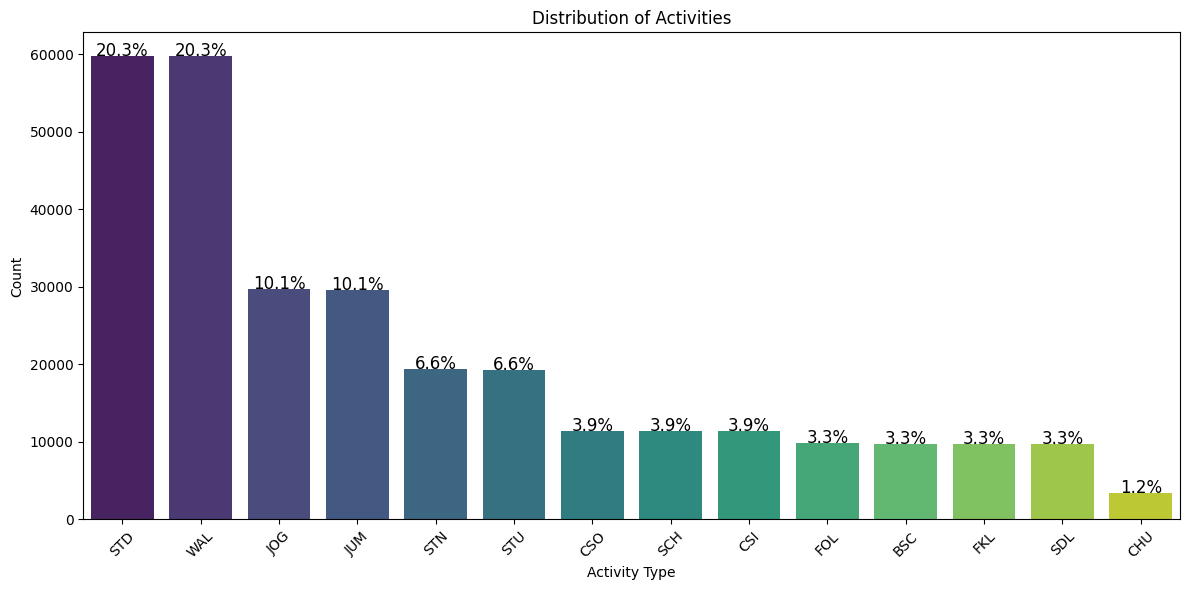

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each activity type
activity_counts = df['Activity Type'].value_counts()

# Calculate the percentage of each activity type
activity_percentages = (activity_counts / activity_counts.sum()) * 100

# Create a bar plot of the activity distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=activity_counts.index, y=activity_counts.values, palette='viridis')

# Add percentage labels on top of each bar
for i, (count, percentage) in enumerate(zip(activity_counts.values, activity_percentages)):
    plt.text(i, count + 0.5, f'{percentage:.1f}%', ha='center', fontsize=12)

# Set plot labels and title
plt.title('Distribution of Activities')
plt.xlabel('Activity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


## 4. Evaluate the Quality of the Dataset
We'll check for missing values and inconsistencies to assess the dataset's quality.

In [7]:
# Check for missing values
missing_values = df.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

# Check for duplicates
duplicate_rows = df.duplicated().sum()

# Display the number of duplicate rows
duplicate_rows

# Check the balance of activities
activity_balance = df['Activity Type'].value_counts(normalize=True) * 100

# Display the balance of activities
activity_balance

Activity Type
STD    20.333358
WAL    20.319092
JOG    10.079552
JUM    10.061549
STN     6.605344
STU     6.570697
CSO     3.877744
SCH     3.867893
CSI     3.867553
FOL     3.338678
BSC     3.312183
FKL     3.304031
SDL     3.303012
CHU     1.159315
Name: proportion, dtype: float64

## 5. Visualize Sensor Data for Each Activity
We'll plot sensor data for a few activities to get an idea of the data quality and patterns.

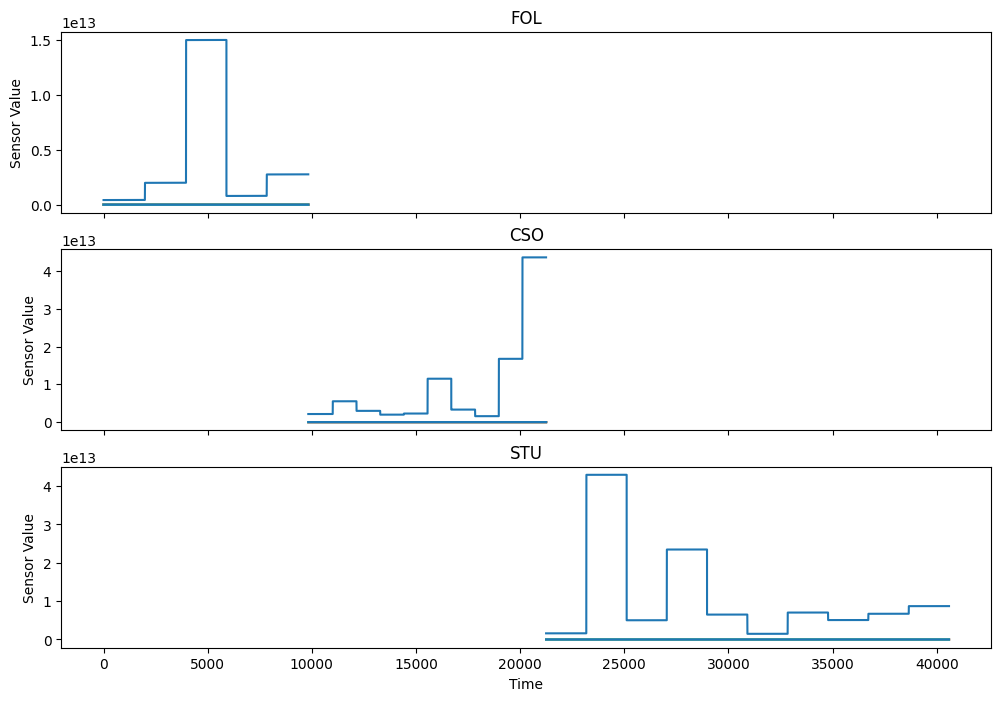

In [8]:
# Sample a few activities to plot
sample_activities = df['Activity Type'].unique()[:3]

# Plot sensor data for each sampled activity
fig, axes = plt.subplots(len(sample_activities), 1, figsize=(12, 8), sharex=True)

for i, activity in enumerate(sample_activities):
    activity_data = df[df['Activity Type'] == activity].iloc[:, :-4]  # Exclude metadata columns
    activity_data.plot(ax=axes[i], title=activity, legend=False)
    axes[i].set_ylabel('Sensor Value')

plt.xlabel('Time')
plt.show()

**Housekeeping**

Checking for blank values, checking Data Types etc.

In [9]:
def overview(df: pd.DataFrame, timestamp_col: str = None) -> None:
    print('Null Count:\n', df.isnull().sum(),'\n')
    print('Data Types:\n', df.dtypes)
    
    if timestamp_col is not None:
        print('\nDate Range:\n\nStart:\t',df[timestamp_col].min())
        print('End:\t',df[timestamp_col].max())
        print('Days:\t',(df[timestamp_col].max() - df[timestamp_col].min()))

In [10]:
overview(df, timestamp_col='timestamp')

Null Count:
 timestamp         0
rel_time          0
acc_x             0
acc_y             0
acc_z             0
gyro_x            0
gyro_y            0
gyro_z            0
azimuth           0
pitch             0
roll              0
label             0
Activity Type     0
Sensor Type       0
Participant ID    0
Trial No          0
Fall              0
dtype: int64 

Data Types:
 timestamp           int64
rel_time          float64
acc_x             float64
acc_y             float64
acc_z             float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
azimuth           float64
pitch             float64
roll              float64
label              object
Activity Type      object
Sensor Type         int64
Participant ID      int64
Trial No           object
Fall                int64
dtype: object

Date Range:

Start:	 182445681000
End:	 132241493648000
Days:	 132059047967000


### Pair for each fall types

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'df' with fall data

# Extract fall data based on fall types
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']
fall_data = df[df['Activity Type'].isin(fall_types)]

print(fall_data.head())
if True == False :
    # Create a pair plot for each fall type
    for fall_type in fall_types:
        fall_type_data = fall_data[fall_data['Activity Type'] == fall_type]

        # Select relevant features for plotting
        features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

        # Create a pair plot
        g = sns.PairGrid(fall_type_data[features], diag_sharey=False)
        g.map_upper(sns.scatterplot, alpha=0.5)
        g.map_lower(sns.kdeplot, fill=True)
        g.map_diag(sns.histplot)

        # Add a title to the plot
        g.fig.suptitle(f"Pair Plot for Fall Type: {fall_type}")

        # Show the plot
        plt.show()

      timestamp  rel_time     acc_x     acc_y     acc_z    gyro_x    gyro_y  \
0  419803971000  0.000000  1.139463  9.650947 -2.207436 -1.246776  0.748615   
1  419809067000  0.005096  1.055384  9.613112 -2.199028 -1.251663  0.734260   
2  419813981000  0.010010  0.995988  9.586384 -2.193089 -1.244943  0.723875   
3  419818963000  0.014992  0.995988  9.586384 -2.193089 -1.247387  0.708604   
4  419824124000  0.020153  0.990052  9.588363 -2.193089 -1.254717  0.689972   

     gyro_z    azimuth      pitch       roll label Activity Type  Sensor Type  \
0  0.058338    0.00000   0.000000  -0.000000   STD           FOL            9   
1  0.066584  359.98425   0.359908  -0.210357   STD           FOL            9   
2  0.070250  354.89110  15.508077  -0.365986   STD           FOL            9   
3  0.077885  306.90152  15.817836  20.787685   STD           FOL            9   
4  0.087354  294.54865  13.428364  13.839194   STD           FOL            9   

   Participant ID   Trial No  Fall  
0

# Pipeline 

#### cuda

In [12]:
import torch
import torch.cuda
import torch.nn.functional as F

# Set the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Explanation



* Data Preparation: We split the normal activities into 80% training and 20% for testing. Fall data is added to the test set.
* One-Class SVM: Trained on the normal activities and used to predict anomalies in the test set.
* VAE: A simple Variational Autoencoder model is trained on normal data and evaluated on both normal and fall data to calculate the reconstruction error.
* Comparison: The reconstruction errors of normal vs. fall activities are plotted, and we expect a separation between them.

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm  # For progress tracking
from sklearn.decomposition import PCA

from sklearn.neighbors import LocalOutlierFactor

## preprocessing for baseline

In [14]:
## Drop columns
try : df = df.drop(['label', 'Activity Type', 'Trial No', 'Sensor Type'], axis=1)  # Simplified dropping
except : None
    
# Step 1: Split Data
df_normal = df[df['Fall'] == 0]
df_fall = df[df['Fall'] == 1]

# 80% of normal data for training, 20% for testing
train_data_normal, test_data_normal = train_test_split(df_normal, test_size=0.2, random_state=42)

# Test set includes 20% normal + all fall data
test_data = pd.concat([test_data_normal, df_fall])


X_train = train_data_normal.drop('Fall', axis=1)
y_train = train_data_normal['Fall']  

X_test = test_data.drop('Fall', axis=1)
y_test = test_data['Fall']  


# Step 2: Data normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Step 2: Data normalization')

Step 2: Data normalization


### LocalOutlierFactor 

I did use this technic instead of OneclassSVM as suggest by you because, my dataset is a bit too large and there is too many features too be hande by OneclassSVM.

In [15]:
# Apply PCA to reduce dimensionality as it takes too long 
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train One-Class SVM on reduced data
# Initialize,fit, predict LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
lof.fit(X_train_pca)
y_pred_lof = lof.predict(X_test_pca)

# Convert -1 to 1 (fall) and 1 to 0 (normal)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)
print('Step 2: Baseline Model: One-Class SVM')


# Reconstruction error for One-Class SVM
lof_error = mean_squared_error(y_test, y_pred_lof)
print(f"Reconstruction Error (One-Class SVM): {lof_error}")

Step 2: Baseline Model: One-Class SVM
Reconstruction Error (One-Class SVM): 0.062016536263248434


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# y_test should already be defined (true labels)
# y_pred_lof is the predicted labels

# Accuracy
accuracy = accuracy_score(y_test, y_pred_lof)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred_lof)
recall = recall_score(y_test, y_pred_lof)
f1 = f1_score(y_test, y_pred_lof)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_lof)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9380
Precision: 0.8819
Recall: 0.9893
F1-Score: 0.9325
Confusion Matrix:
[[45903  5171]
 [  417 38614]]


### Variational Autoencoder

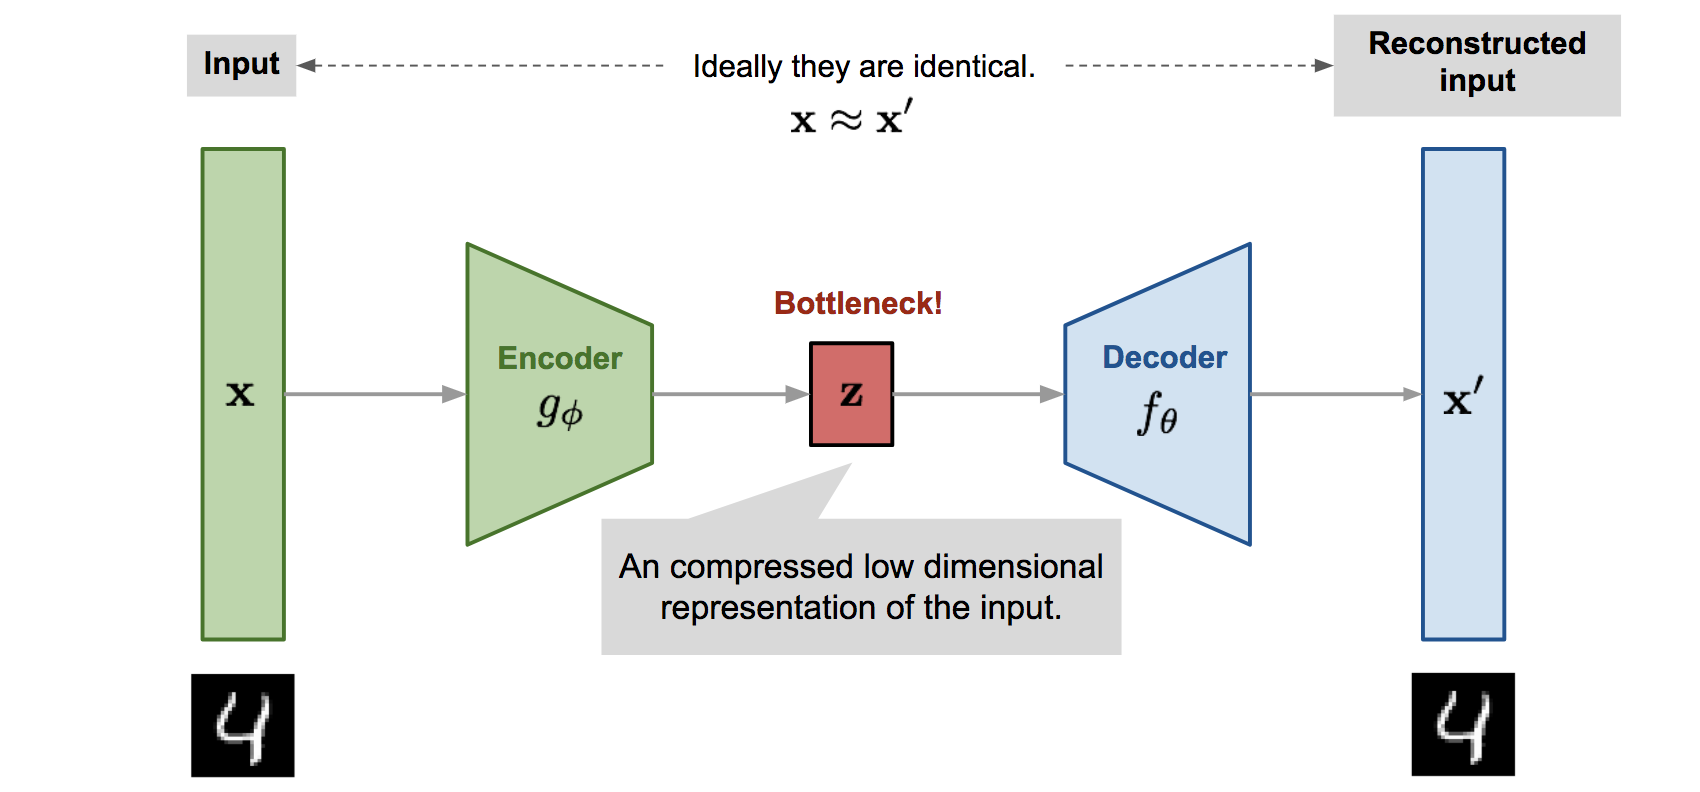

Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Reconstruction Error (VAE): 0.8479876518249512 

Accuracy (VAE): 0.5763
Precision (VAE): 0.5718
Recall (VAE): 0.0874
F1-Score (VAE): 0.1516
Confusion Matrix (VAE):
[[48520  2554]
 [35620  3411]]


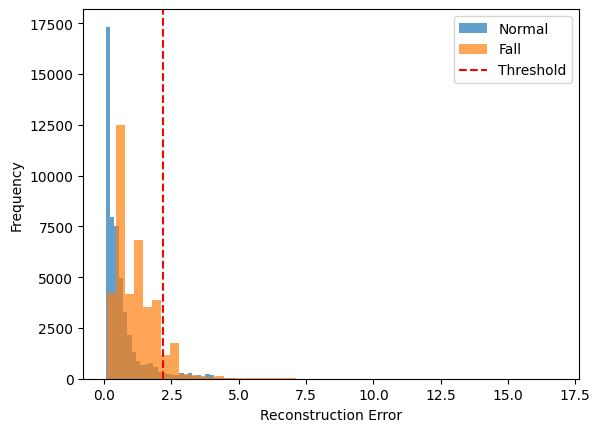

In [17]:
### Advanced Model: Variational Autoencoder (VAE) ###
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE Training Setup
input_dim = X_train_scaled.shape[1]
hidden_dim = 32
latent_dim = 12
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)  # Move model to GPU if available
optimizer = optim.Adam(vae.parameters(), lr=0.006)
criterion = nn.MSELoss()

# Convert data to torch tensors and move them to the GPU if available
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# VAE Training Loop with tqdm for progress
num_epochs = 500
vae.train()
for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    optimizer.zero_grad()
    recon_batch, mu, logvar = vae(X_train_tensor)
    loss = criterion(recon_batch, X_train_tensor)
    loss.backward()
    optimizer.step()
    #if epoch % 10 == 0 : 
    #    tqdm.write(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# VAE Testing (Reconstruction Error)
vae.eval()
with torch.no_grad():
    recon_test, _, _ = vae(X_test_tensor)
    recon_error_vae = torch.mean((recon_test - X_test_tensor) ** 2, dim=1).cpu().numpy()

    
########################  Metrics ########################
    
    
# Compare Reconstruction Errors
print(f"Reconstruction Error (VAE): {np.mean(recon_error_vae)} \n")

#Determine a threshold for classification
# You could use a heuristic or statistical method like mean + k*std_dev of reconstruction errors on normal data
threshold = np.percentile(recon_error_vae[y_test == 0], 95)  # Example: 95th percentile of normal data reconstruction errors

# Classify based on reconstruction error
y_pred_vae = np.where(recon_error_vae > threshold, 1, 0)  # 1 for fall (anomaly), 0 for normal

# Metrics
accuracy = accuracy_score(y_test, y_pred_vae)
print(f"Accuracy (VAE): {accuracy:.4f}")
precision = precision_score(y_test, y_pred_vae)
recall = recall_score(y_test, y_pred_vae)
f1 = f1_score(y_test, y_pred_vae)

print(f"Precision (VAE): {precision:.4f}")
print(f"Recall (VAE): {recall:.4f}")
print(f"F1-Score (VAE): {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_vae)
print("Confusion Matrix (VAE):")
print(conf_matrix)

# Visualize the separation between normal and fall activities
plt.hist(recon_error_vae[y_test == 0], bins=50, alpha=0.7, label="Normal")
plt.hist(recon_error_vae[y_test == 1], bins=50, alpha=0.7, label="Fall")
plt.axvline(x=threshold, color='r', linestyle='--', label="Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Train Models

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

## LSTM model

In [19]:
class MHSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MHSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "Embedding dimension must be divisible by number of heads"

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.size(0)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attn = F.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)

        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

        return self.out(context)

class LSTM_SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads, fc_layers, embedding_dim):
        super(LSTM_SelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.self_attn = MHSelfAttention(embedding_dim, num_heads)
        
        fc_layer_sizes = [hidden_dim] + fc_layers
        self.fc_layers = nn.ModuleList()
        for in_size, out_size in zip(fc_layer_sizes[:-1], fc_layer_sizes[1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())
        self.output_layer = nn.Linear(fc_layers[-1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.LSTM(x)
        x = self.self_attn(x)
        
        x = x[:, -1, :]  # Use the output of the last timestep or aggregate as needed
        
        for layer in self.fc_layers:
            x = layer(x)
        
        x = self.output_layer(x).squeeze(-1)  # Ensure output shape is [batch_size]
        
        return x

## GRU model

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MHSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MHSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "Embedding dimension must be divisible by number of heads"

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.size(0)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attn = F.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)

        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

        return self.out(context)

class GRU_SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads, fc_layers, embedding_dim):
        super(GRU_SelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.GRU = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.self_attn = MHSelfAttention(embedding_dim, num_heads)
        
        fc_layer_sizes = [hidden_dim] + fc_layers
        self.fc_layers = nn.ModuleList()
        for in_size, out_size in zip(fc_layer_sizes[:-1], fc_layer_sizes[1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())
        self.output_layer = nn.Linear(fc_layers[-1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.GRU(x)
        x = self.self_attn(x)
        
        x = x[:, -1, :]  # Use the output of the last timestep or aggregate as needed
        
        for layer in self.fc_layers:
            x = layer(x)
        
        x = self.output_layer(x).squeeze(-1)  # Ensure output shape is [batch_size]
        
        return x

#### **drop columns**



In [21]:
try : 
    df = df.drop('label', axis=1) # as we already encoded the labels with fall (boolean)
    df = df.drop('Activity Type', axis=1) # as we already encoded the labels with fall (boolean)
    df = df.drop('Trial No', axis=1) # as we already encoded the labels with fall (boolean)
    df = df.drop('Sensor Type', axis=1) # as we already encoded the labels with fall (boolean)
except:
    None

## Prepare dataset

#### Classic split of data

In [22]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

# Convert non-numeric columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Separate features (X) and target (y)
X = torch.from_numpy(df.drop('Fall', axis=1).values)
y = torch.from_numpy(df['Fall'].values)

print(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

X_train = torch.clamp(X_train, min=0, max=X_train.shape[1]-1) # X_train.shape[1] = input_dim
X_test = torch.clamp(X_test, min=0, max=X_train.shape[1]-1)

# Create DataLoaders
batch_size = 64
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

tensor([[ 4.1980e+11,  0.0000e+00,  1.1395e+00,  ...,  0.0000e+00,
         -0.0000e+00,  1.0000e+00],
        [ 4.1981e+11,  5.0960e-03,  1.0554e+00,  ...,  3.5991e-01,
         -2.1036e-01,  1.0000e+00],
        [ 4.1981e+11,  1.0010e-02,  9.9599e-01,  ...,  1.5508e+01,
         -3.6599e-01,  1.0000e+00],
        ...,
        [ 4.1286e+12,  5.6800e+00,  9.6664e-01,  ..., -9.9313e+01,
          5.7246e+00,  4.0000e+00],
        [ 4.1286e+12,  5.6849e+00,  9.6658e-01,  ..., -9.9316e+01,
          5.7314e+00,  4.0000e+00],
        [ 4.1286e+12,  5.6900e+00,  9.4281e-01,  ..., -9.9319e+01,
          5.7383e+00,  4.0000e+00]], dtype=torch.float64)


/tmp/ipykernel_24/3184919072.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.long).to(device)
/tmp/ipykernel_24/3184919072.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_24/3184919072.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.long).to(device)
/tmp/ipykernel_24/3184919072.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

#### split : Test set includes 20% normal dataset + all falls data 

In [23]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Assuming df is the input DataFrame and 'Fall' is the target column.

# Convert non-numeric columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

df_normal = df[df['Fall'] == 0]  # Normal activities
df_fall = df[df['Fall'] == 1]    # Fall activities

# 80% of normal data for training, 20% for testing
train_data_normal, test_data_normal = train_test_split(df_normal, test_size=0.2, random_state=42)

# Test set includes 20% normal + all fall data
test_data = pd.concat([test_data_normal, df_fall])

# Step 5: Separate features (X) and target (y) for training and testing sets
X_train = train_data_normal.drop('Fall', axis=1)
y_train = train_data_normal['Fall']

X_test = test_data.drop('Fall', axis=1)
y_test = test_data['Fall']

# Step 6: Convert pandas DataFrame to PyTorch tensors ahnd device 
X_train = torch.tensor(X_train.values, dtype=torch.long).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.long).to(device)

X_test = torch.tensor(X_test.values, dtype=torch.long).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.long).to(device)


# Step 7: Apply clamping if necessary (to limit the values within a certain range)
# Assuming we want to clamp to the valid input feature range
input_dim = X_train.shape[1]
X_train = torch.clamp(X_train, min=0, max=input_dim-1)  # Adjust clamp as needed
X_test = torch.clamp(X_test, min=0, max=input_dim-1)

# Step 8: Create DataLoaders for batch processing
batch_size = 64
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Hyperparameters

In [24]:
input_dim = X_train.shape[1]  # Number of input features
hidden_dim = 32  # Number of hidden units in LSTM
output_dim = 1  # Number of output classes has the num of classes 
num_layers = 4  # Number of LSTM layers
dropout = 0.2  # Dropout probability
fc_layers = [32, 16, 8]  # Adjust the number and size of fully connected layers
learning_rate = 0.001
num_heads = 2  # Number of self-attention heads
embedding_dim = 32  # Embedding dimension
num_epochs = 5  # Number of training epochs

In [25]:
# !conda install pytorch torchvision cudatoolkit=9.0 -c pytorch

## Train loop

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model, criterion, and optimizer
# model = LSTM_SelfAttention(input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads, fc_layers, embedding_dim)
model = GRU_SelfAttention(input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads, fc_layers, embedding_dim)

# Wrap model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize TensorBoard SummaryWriter
log_name = f"GRU_SelfAttention_epochs_{num_epochs}_lr_{learning_rate}_batch_{batch_size}_layers_{'_'.join(map(str, fc_layers))}_heads_{num_heads}"
log_dir = f"./logs/{log_name}"
writer = SummaryWriter(log_dir, filename_suffix=log_name)

# Lists to store losses and accuracies for plotting
train_losses = []
test_accuracies = []

# Variables to accumulate true labels and predictions across all epochs
y_true_all = []
y_pred_all = []

# Function to train the model for one epoch
def train_one_epoch(epoch, model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(train_loader, desc=f'Training Epoch {epoch+1}', leave=False)):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        # print(outputs)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + batch_idx)
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Avg Training Loss: {avg_loss:.4f}")
    return avg_loss

# Function to evaluate the model and accumulate predictions and true labels
def evaluate_and_accumulate(model, test_loader, y_true_all, y_pred_all):
    model.eval()
    total_accuracy = 0

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc='Evaluating', leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            outputs = model(X_batch)
            y_hat = torch.round(torch.sigmoid(outputs))  # Binarized predictions
            accuracy = (y_hat == y_batch).sum().item() / len(y_batch)
            total_accuracy += accuracy
            
            # Accumulate true and predicted labels for confusion matrix
            y_true_all.extend(y_batch.cpu().numpy())
            y_pred_all.extend(y_hat.cpu().numpy())

    avg_accuracy = total_accuracy / len(test_loader)
    test_accuracies.append(avg_accuracy)
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    
    return avg_accuracy

# Main training loop
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, train_loader, criterion, optimizer)
    evaluate_and_accumulate(model, test_loader, y_true_all, y_pred_all)

# Save the model
torch.save(model.state_dict(), 'model.pth')

# Close TensorBoard writer
writer.close()


Using device: cuda


Training Epoch 1:   0%|          | 0/3193 [00:00<?, ?it/s]

Epoch 1 - Avg Training Loss: 0.0089


Evaluating:   0%|          | 0/1408 [00:00<?, ?it/s]

Test Accuracy: 0.5668


Training Epoch 2:   0%|          | 0/3193 [00:00<?, ?it/s]

Epoch 2 - Avg Training Loss: 0.0000


Evaluating:   0%|          | 0/1408 [00:00<?, ?it/s]

Test Accuracy: 0.5668


Training Epoch 3:   0%|          | 0/3193 [00:00<?, ?it/s]

Epoch 3 - Avg Training Loss: 0.0000


Evaluating:   0%|          | 0/1408 [00:00<?, ?it/s]

Test Accuracy: 0.5668


Training Epoch 4:   0%|          | 0/3193 [00:00<?, ?it/s]

Epoch 4 - Avg Training Loss: 0.0000


Evaluating:   0%|          | 0/1408 [00:00<?, ?it/s]

Test Accuracy: 0.5668


Training Epoch 5:   0%|          | 0/3193 [00:00<?, ?it/s]

Epoch 5 - Avg Training Loss: 0.0000


Evaluating:   0%|          | 0/1408 [00:00<?, ?it/s]

Test Accuracy: 0.5668


## Test visualization model

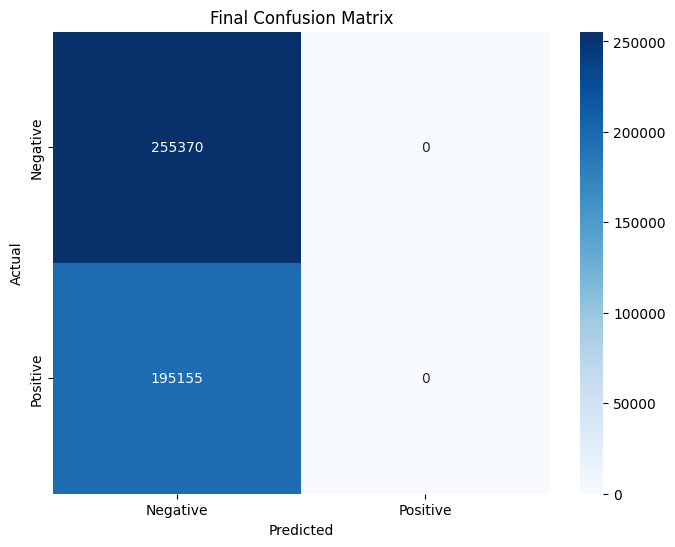

In [27]:
# Generate final confusion matrix and heatmap after all epochs
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Final Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# plt.savefig("final_confusion_matrix.png")
plt.show()

In [28]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(y_true_all, y_pred_all, target_names=["Non-Fall", "Fall"])
print("Classification Report:\n", class_report)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

    Non-Fall       0.57      1.00      0.72    255370
        Fall       0.00      0.00      0.00    195155

    accuracy                           0.57    450525
   macro avg       0.28      0.50      0.36    450525
weighted avg       0.32      0.57      0.41    450525



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Tensorboard

In [29]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir "/kaggle/working/logs"

# Results and explanation 

### CNNs

I have obtain really different result from the two different way of split the dataset with the same models (GRU_SelfAttention and LSTM_SelfAttention).

#### Classic split as 80% of the all dataset on Training, 20% on testing :
- We can see that i reached 97% accuracy with GRU
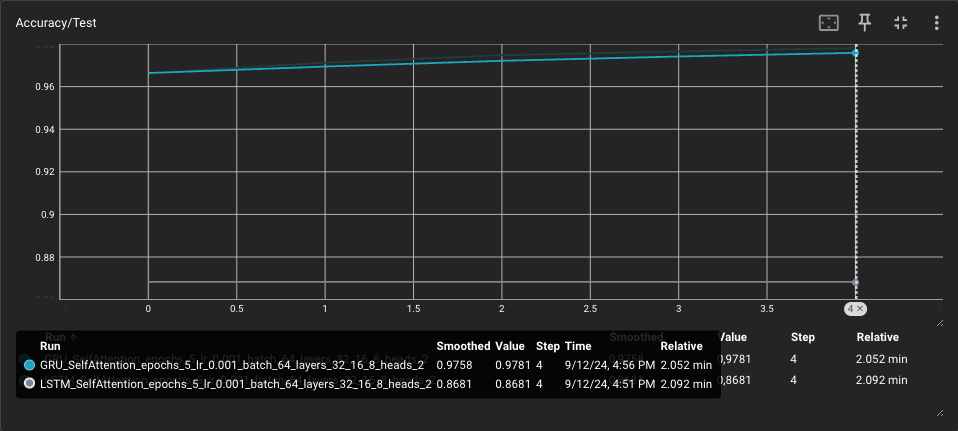


#### Test on the fall data + 20% of normal activities : 
i tried a lot of different thing and i could not have even have one fall activity well identify. 
